Importing Libraries

In [1]:
import math
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta
plt.style.use('fivethirtyeight')

Importing Data

In [2]:
yf.pdr_override()
td = date.today()-timedelta(days = 2)

In [3]:
df = pdr.get_data_yahoo('BTC-USD', start='2010-1-1', end = td)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-05-18,67066.210938,67387.328125,66663.500000,66940.804688,66940.804688,16712277406
2024-05-19,66937.929688,67694.296875,65937.179688,66278.367188,66278.367188,19249094538
2024-05-20,66278.742188,71483.562500,66086.171875,71448.195312,71448.195312,43850655717


In [5]:
#no of rows n col
df.shape

(3536, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3536 entries, 2014-09-17 to 2024-05-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3536 non-null   float64
 1   High       3536 non-null   float64
 2   Low        3536 non-null   float64
 3   Close      3536 non-null   float64
 4   Adj Close  3536 non-null   float64
 5   Volume     3536 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 193.4 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3536.0,1.631112e+04,1.810539e+04,1.768970e+02,1.035762e+03,8.757644e+03,2.713060e+04,7.307938e+04
High,3536.0,1.669144e+04,1.853610e+04,2.117310e+02,1.052200e+03,8.927101e+03,2.746842e+04,7.375007e+04
Low,3536.0,1.590596e+04,1.763371e+04,1.715100e+02,1.014922e+03,8.552497e+03,2.671360e+04,7.133409e+04
Close,3536.0,1.632930e+04,1.812285e+04,1.781030e+02,1.037798e+03,8.757109e+03,2.714483e+04,7.308350e+04
Adj Close,3536.0,1.632930e+04,1.812285e+04,1.781030e+02,1.037798e+03,8.757109e+03,2.714483e+04,7.308350e+04
Volume,3536.0,1.722278e+10,1.924747e+10,5.914570e+06,2.255415e+08,1.305335e+10,2.782260e+10,3.509679e+11


Checking duplicate rows

In [8]:
df.duplicated().sum()

0

Checking Missing values

In [9]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Checking for categorical columns

In [10]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Exploratory Data Analysis

> Analysing close price

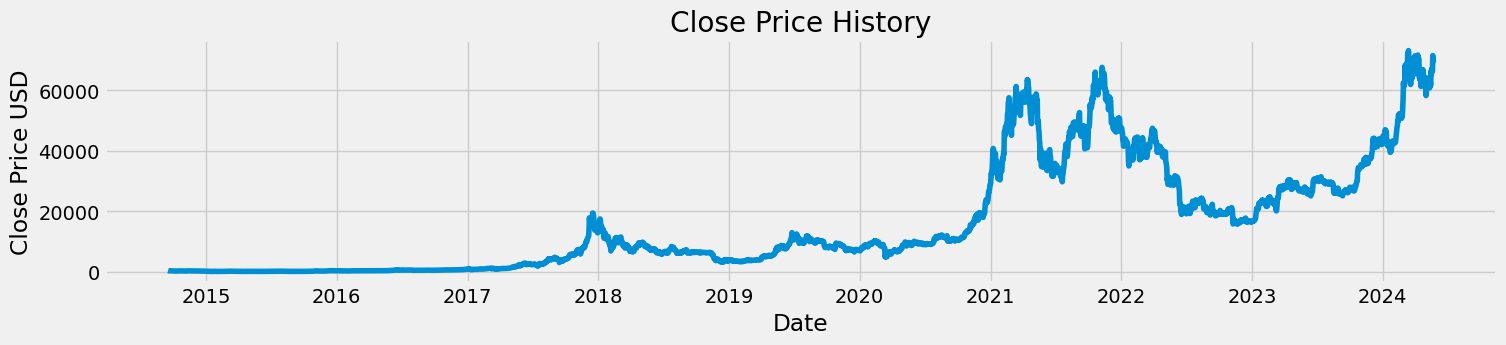

In [11]:
plt.figure(figsize = (16,3))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

> Analysis volume being traded each day

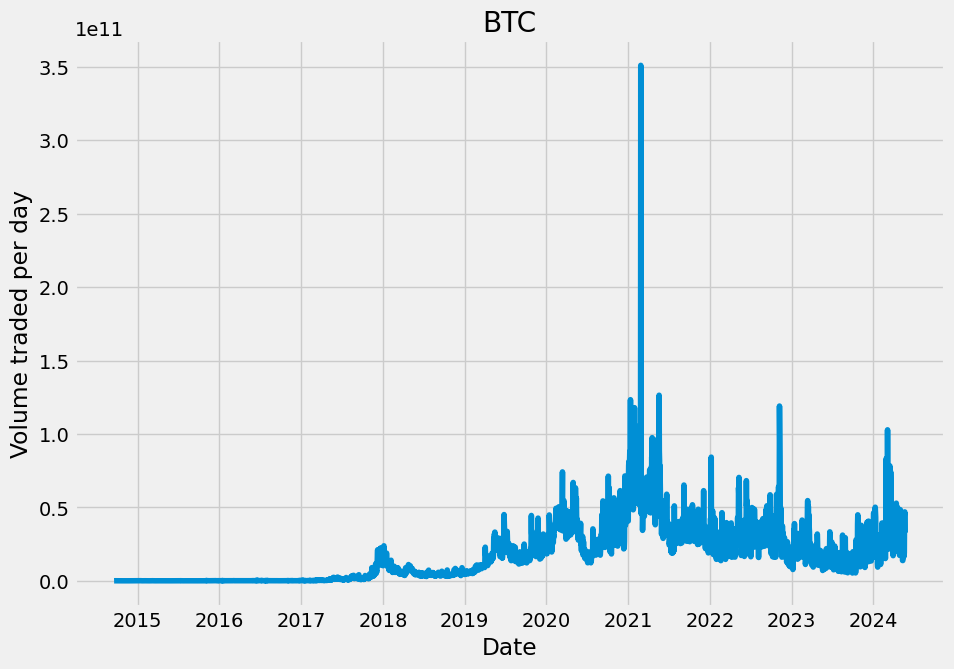

In [12]:
plt.figure(figsize = (10,7))
plt.title('BTC')
plt.plot(df['Volume'])
plt.xlabel('Date')
plt.ylabel('Volume traded per day')
plt.show()

> Monthly change in mean closing price

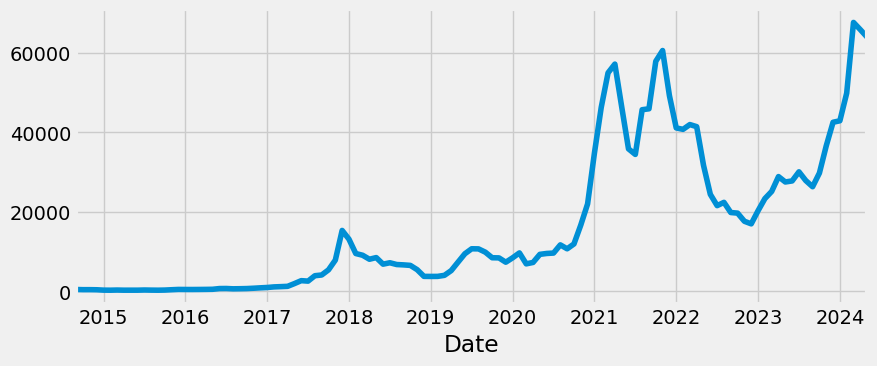

In [13]:
plt.figure(figsize = (20,8))
plt.subplot(2,2,1)
df['Close'].resample('M').mean().plot()
plt.show()

Splitting into dependent(target) and independent(featured) varaibles

In [14]:
# create a new dataframe with only the close column
data = df.filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the LSTM model on
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2829

Data Preprocessing

In [15]:
#Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[-0.87592246],
       [-0.87773777],
       [-0.87937373],
       ...,
       [ 3.0418338 ],
       [ 2.9694473 ],
       [ 2.91347713]])

Splitting Data into train data sets 

In [16]:
#create the scaled training dataset
train_data = scaled_data[0: training_data_len,:]
train_data

#splitting data into x_train and y_train
x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60: i, 0]) # from position 1 to 60 => index : 0 to 59
    y_train.append(train_data[i, 0]) # position 61th => 60th index
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([-0.87592246, -0.87773777, -0.87937373, -0.87859515, -0.8791516 ,
       -0.87896777, -0.87711135, -0.87780593, -0.8784478 , -0.87884233,
       -0.87911303, -0.88034584, -0.88044043, -0.87980705, -0.87999077,
       -0.88046223, -0.88132094, -0.88301219, -0.88347333, -0.88294525,
       -0.88260817, -0.88168362, -0.88101664, -0.8812078 , -0.88116713,
       -0.88027035, -0.87961556, -0.87903852, -0.879375  , -0.88004921,
       -0.87998288, -0.87955882, -0.87966346, -0.88003326, -0.87983294,
       -0.88001599, -0.88138137, -0.88138534, -0.88199648, -0.88158627,
       -0.88168092, -0.88142546, -0.88264106, -0.88210498, -0.8824904 ,
       -0.88318421, -0.88317632, -0.8830846 , -0.88292246, -0.88242611,
       -0.88188506, -0.88226446, -0.88209488, -0.88111388, -0.88091189,
       -0.88086934, -0.87778628, -0.87794224, -0.87920695, -0.88040368])]
[-0.879755289197]

[array([-0.87592246, -0.87773777, -0.87937373, -0.87859515, -0.8791516 ,
       -0.87896777, -0.87711135, -0.87780

In [17]:
#converting x_train and y_train to arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
#reshaping the x_train dataset
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 2551,60,1
x_train.shape
#Since the LSTM model except data to be a 3d matrix

(2769, 60, 1)

Modelling and Tuning

In [19]:
#building lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1))) # no .of neurons = 50 , input = 60,1 # return true means more lstm layers expected
model.add(LSTM(50, return_sequences=False)) # false means no more layers
model.add(Dense(25)) # 25 neurons
model.add(Dense(1)) # 1 neuron

In [20]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error') # optimizer imporve upon the loss function
#=> our adam optimizer will improve upon the mean_squared_error

In [21]:
#train the model
np.random.seed(25)
model.fit(x_train, y_train, batch_size=20, epochs=15) # epoch => no of iteration , # bathc_size : no of train dataset

Epoch 1/15
139/139 [==============================] - 38s 80ms/step - loss: 0.0447
Epoch 2/15
139/139 [==============================] - 11s 80ms/step - loss: 0.0088
Epoch 3/15
139/139 [==============================] - 27s 195ms/step - loss: 0.0069
Epoch 4/15
139/139 [==============================] - 11s 80ms/step - loss: 0.0064
Epoch 5/15
139/139 [==============================] - 11s 76ms/step - loss: 0.0062
Epoch 6/15
139/139 [==============================] - 11s 79ms/step - loss: 0.0051
Epoch 7/15
139/139 [==============================] - 11s 77ms/step - loss: 0.0041
Epoch 8/15
139/139 [==============================] - 13s 90ms/step - loss: 0.0042
Epoch 9/15
139/139 [==============================] - 12s 84ms/step - loss: 0.0036
Epoch 10/15
139/139 [==============================] - 11s 82ms/step - loss: 0.0039
Epoch 11/15
139/139 [==============================] - 11s 78ms/step - loss: 0.0032
Epoch 12/15
139/139 [==============================] - 10s 69ms/step - loss: 0.0031


Splitting data into test datasets

In [83]:
#create the testing dataset
#create new array containing test values
test_data = scaled_data[training_data_len-60:,:]
#create dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [84]:
#convert data into numpy array
x_test = np.array(x_test)

In [85]:
#reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [86]:
x_test.shape

(652, 60, 1)

Making Predicitons

In [87]:
#get the models predicted price values
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction) # kind of unscaling

21/21 [==============================] - 1s 16ms/step


Evaluation 


> using root mean squared error

In [88]:
# get the rmse [ more lower more better ]
rmse = np.sqrt(np.mean(prediction-y_test)**2)
rmse

129.67779129121934

> using mean absolute percentage error

In [89]:
# get the mean absolute percentage error
prediction, y_test = np.array(prediction), np.array(y_test)
mape = np.mean(np.abs((y_test - prediction) / y_test)) * 100
mape

2.3662655677957685

C:\Users\ameer\AppData\Local\Temp\ipykernel_25500\3453032648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = prediction


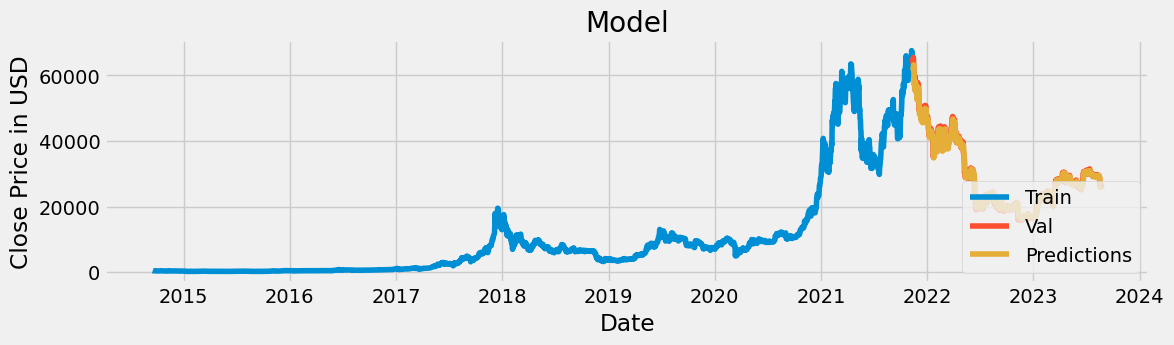

In [90]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = prediction
#visualize data
plt.figure(figsize = (12,3))
plt.title("Model")
plt.xlabel('Date')
plt.ylabel('Close Price in USD')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [91]:
#show valid and predicted prices
valid

,Close,Predictions
Date,,
2021-11-11,64949.960938,62590.902344
2021-11-12,64155.941406,62492.652344
2021-11-13,64469.527344,61903.335938
2021-11-14,65466.839844,62243.027344
2021-11-15,63557.871094,63243.726562
...,...,...
2023-08-20,26189.583984,25953.828125
2023-08-21,26124.140625,25920.439453
2023-08-22,26031.656250,25974.695312


Inputting Format

In [92]:
#get the quote
today = date.today()-timedelta(days = 3)
btc_quote = pdr.get_data_yahoo('BTC-USD', start='2010-1-1', end = today)
#create a new dataframe
new_df = btc_quote.filter(['Close'])
#get last 60 day closing value and convert to array
last_60_days = new_df[-60:].values
#scale data to values between 0 and 1
last_60_daya_scled = scaler.transform(last_60_days)
# last_60_daya_scled
X_test = []
# #append past 60 days to X_test
X_test.append(last_60_daya_scled)
# X_test
# #Convert X_test dataset to numpy array
X_test = np.array(X_test)
# #reshape data
X_test = np.reshape(X_test, (X_test.shape[0] ,X_test.shape[1],1))
# #get predicted price
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 23ms/step
[[26221.21]]


In [93]:
btc_quote_2 = pdr.get_data_yahoo('BTC-USD', start='2010-1-1', end = td)
print(btc_quote_2)

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2023-08-20  26096.861328  26260.681641  26004.314453  26189.583984   
2023-08-21  26188.691406  26220.201172  25846.087891  26124.140625   
2023-08-22  26130.748047  26135.507812  25520.728516  26031.656250   
2023-08-23  26040.474609  26786.898438  25804.998047  26431.640625   
2023-08-24  26431.519531  26554.910156  25914.925781  26162.373047   

               Adj C

Saving the model

In [103]:
#Saving the model
model.save("model")